# Resampling

In [15]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
## fastai imports
from fastai.basics import *
from fastai.data_block import ItemList
from fastai.vision import *
from exp.nb_AudioCommon import *
from exp.nb_DataBlock import *
from exp.nb_DataAugmentation import *

In [17]:
## The actual url is http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS.tgz
## but we need to strip off the extension otherwise fastai gets confused.
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
## Need this because the source tar file doesn't extract to its own folder
data_folder = datapath4file(url2name(data_url))

In [31]:
audios = AudioList.from_folder(data_folder, nsr=8000); audios

TypeError: __init__() got an unexpected keyword argument 'nsr'

160000

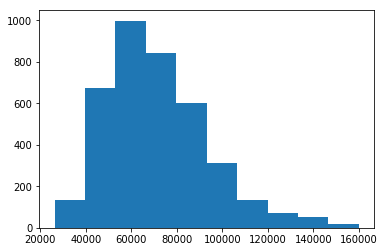

In [19]:
audio_lengths = tensor([a.data.sig.shape[0] for a in audios])
plt.hist(audio_lengths);
audio_lengths.max().item()

In [20]:
def tfms_sr(resample_rate):
    return get_audio_transforms(resample_rate=resample_rate,
                            spectro=True,
                            mx_to_pad=audio_lengths.max().item(),
                            white_noise=False,
                            modulate_volume=False,
                            random_cutout=False,
                            pad_with_silence=False,
                            pitch_warp=False,
                            down_and_up=False,
                            n_mels=64, ws=300, n_fft=1024, to_db_scale=True
    )

In [21]:
## Regex to get the speaker ID in our file name (our label)
label_pattern = r'_([mf]\d+)_'
bs = 64
label_data = (audios
        .split_by_rand_pct(0.2, seed=2)
        .label_from_re(label_pattern)
 )

In [22]:
def make_learner(data):
    newlayer = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    newlayer = newlayer.cuda() # Our layer should use cuda, since the rest of the model will.
    ## Standard learner
    learn = cnn_learner(data, models.resnet18, metrics=accuracy)
    ## Replace the first layer in the resnet18 model with our first layer
    learn.model[0][0] = newlayer
    return learn

In [28]:
for i in [None, 15500, 12000, 10000, 8000]:
    tfms = tfms_sr(i)
    print("Using sample rate: ", i)
    db = label_data.transform(tfms).databunch(bs=bs)
    db.train_ds[0][0].show()1
    learn = make_learner(db)
    learn.fit_one_cycle(2)

Using sample rate:  None


epoch,train_loss,valid_loss,accuracy,time
0,1.374741,1.070973,0.654948,00:12
1,0.832884,0.632020,0.786458,00:12


Using sample rate:  15500


epoch,train_loss,valid_loss,accuracy,time
0,1.356658,1.451564,0.574219,00:21
1,0.787608,0.645931,0.777344,00:21


Using sample rate:  12000


epoch,train_loss,valid_loss,accuracy,time
0,1.534957,3.012204,0.285156,00:17
1,0.951991,2.099240,0.403646,00:17


Using sample rate:  10000


epoch,train_loss,valid_loss,accuracy,time
0,1.340434,5.599148,0.173177,00:16
1,0.795560,4.219325,0.218750,00:17


Using sample rate:  8000


epoch,train_loss,valid_loss,accuracy,time
0,1.371192,7.334645,0.123698,00:16
1,0.848794,5.735779,0.138021,00:16
